In [1]:
import os
import io
import PIL.Image, PIL.ImageDraw
import matplotlib.pyplot as plt
import requests
import logging
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import time

# Notebook dependencies
from IPython.display import clear_output, Image

# Custom helpers package
from helpers import *

# For reloading the helpers package
import importlib
import sys
importlib.reload(sys.modules['helpers'])
from helpers import *

# Load models
from noised_rgb import CANet, DiffusionCA, Train
from nca import NCAModel, TrainNCA
from diffusionCA import CADiff, Diffusion, TrainDiff
# from diffusionNCA import NCADiff, Diffusion, TrainDiff


# Reload
importlib.reload(sys.modules['nca'])
# importlib.reload(sys.modules['diffusionNCA'])
importlib.reload(sys.modules['diffusionCA'])
from nca import NCAModel, TrainNCA
from diffusionCA import CADiff, Diffusion, TrainDiff
# from diffusionNCA import NCADiff, Diffusion, TrainDiff

# Set cuda gpu
device_id = 1
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
print(f'device is {device}')

logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

Finished imports from file
device is cuda:2
device is cuda:1
Finished imports from file
device is cuda:1
device is cuda:1
Finished imports from file
device is cuda:1
device is cuda:1


In [3]:
def get_cifar(download=False, img_size=28, batch_size=8):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    K = 5000
    
    dataset_cifar = torchvision.datasets.CIFAR10(root='datasets', train=False, download=download, transform=transforms)
    subsample_train_indices = torch.randperm(len(dataset_cifar))[:K]
    subloader_cifar = torch.utils.data.DataLoader(dataset_cifar, batch_size=batch_size, 
                              sampler=torch.utils.data.SubsetRandomSampler(subsample_train_indices))     
    return subloader_cifar

dataloader_cifar = get_cifar(download=False)


In [5]:
BATCH_SIZE = 8

def get_dtd():
    img_size, batch_size = 28, 8

    transforms = torchvision.transforms.Compose([
        # torchvision.transforms.Resize(80),
        torchvision.transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)) # global mean and std of MNIST
    ])
    K = 1000 # enter your length here
    dataset_dtd = torchvision.datasets.DTD(root='datasets', download=False, transform=transforms)
    
    
    subsample_train_indices = torch.randperm(len(dataset_dtd))[:K]
    subloader_dtd = torch.utils.data.DataLoader(dataset_dtd, batch_size=8, 
                              sampler=torch.utils.data.SubsetRandomSampler(subsample_train_indices))    
    
    return subloader_dtd  


def get_dataloader():
    img_size, batch_size = 28, BATCH_SIZE

    transforms = torchvision.transforms.Compose([
        # torchvision.transforms.Resize(80),
        torchvision.transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)) # global mean and std of MNIST
    ])

    K = 1000 # enter your length here
    dataset_mnist = torchvision.datasets.MNIST(root='datasets', train=False, download=False, transform=transforms)
    subsample_train_indices = torch.randperm(len(dataset_mnist))[:K]
    subloader_mnist = torch.utils.data.DataLoader(dataset_mnist, batch_size=BATCH_SIZE, 
                              sampler=torch.utils.data.SubsetRandomSampler(subsample_train_indices))    
    
    return subloader_mnist        
        

# dataset_dtd = get_dtd()
# len(dataset_dtd)

loaders = torch.load('mnist_classed.pkl')
# dataloader_5 = loaders[5] # MNIST for the 5 class
subloader_mnist = get_dataloader()

In [8]:
url = 'https://www.robots.ox.ac.uk/~vgg/data/dtd/thumbs/dotted/dotted_0201.jpg'
polkadots_img = imread(url, max_size=64)

# For singly imported images
def make_dataloader(target_img, n_images=1, batch_size=8):
    """
        Note: Expects pad_target to have shape (4, 64, 64)
    """
    batched_data = torch.repeat_interleave(target_img[None, ...], batch_size, dim=0) 
    return [(batched_data, 'label')] * n_images
    
    url = 'https://www.robots.ox.ac.uk/~vgg/data/dtd/thumbs/dotted/dotted_0201.jpg'
    polkadots_img = imread(url, max_size=64)
    
# Convert and transform
img_size, batch_size = 64, 8
transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,)) # global mean and std of MNIST
])
target_img = transforms(np2pil(polkadots_img))

# Make dataloader from target
dataloader_polkadots = make_dataloader(target_img, n_images=200)  

In [19]:
%%time

c_noise = 1
channel_n = 90
perception_size = 360
hidden_size = 1024

ca_diff = CADiff(c_in=channel_n, c_noise=c_noise, hidden_size=hidden_size, 
                 perception_size=perception_size).to(device)

diffusion = Diffusion(c_in=channel_n, c_noise=c_noise, noise_steps=500, img_size=28, lower=70, upper=100)

ckpt = torch.load('./models/CADiff_big500long_MNIST_all/ckpt180.pt')
ca_diff.load_state_dict(ckpt)


CPU times: user 2.66 s, sys: 177 ms, total: 2.83 s
Wall time: 221 ms


<All keys matched successfully>

In [20]:
start_time = time.time() # time training run    

run_name = 'CADiff_big500long_MNIST_all_1'
train_diff = TrainDiff(ca_diff, diffusion, dataloader=subloader_mnist, c_in=channel_n,
                       c_noise=c_noise, run_name=run_name, lower=70, upper=100)

losses = train_diff.train(epochs=201)            

elapsed_time = np.round((time.time() - start_time) / 60, decimals=4)
print(f'\nElapsed time for training run for {run_name}: {elapsed_time}')

03:32:30 - INFO: Starting epoch 0:


Starting epoch 0:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:27<00:00,  1.43it/s, MSE=0.0146]
03:33:57 - INFO: Sampling 8 new images...


Sampling 8 images


499it [02:16,  3.66it/s]
03:36:13 - INFO: Starting epoch 1:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 1:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.0171]
03:37:35 - INFO: Starting epoch 2:


Starting epoch 2:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.56it/s, MSE=0.00608]
03:38:55 - INFO: Starting epoch 3:


Starting epoch 3:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:19<00:00,  1.57it/s, MSE=0.0377]
03:40:14 - INFO: Starting epoch 4:


Starting epoch 4:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:19<00:00,  1.56it/s, MSE=0.0044]
03:41:34 - INFO: Starting epoch 5:


Starting epoch 5:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.56it/s, MSE=0.00112]
03:42:55 - INFO: Starting epoch 6:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 6:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:19<00:00,  1.57it/s, MSE=0.0441]
03:44:14 - INFO: Starting epoch 7:


Starting epoch 7:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.55it/s, MSE=0.0154]
03:45:35 - INFO: Starting epoch 8:


Starting epoch 8:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:19<00:00,  1.56it/s, MSE=0.00684]
03:46:55 - INFO: Starting epoch 9:


Starting epoch 9:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:19<00:00,  1.57it/s, MSE=0.003]
03:48:15 - INFO: Starting epoch 10:


Starting epoch 10:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.56it/s, MSE=0.032]
03:49:35 - INFO: Starting epoch 11:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 11:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:19<00:00,  1.57it/s, MSE=0.0342]
03:50:55 - INFO: Starting epoch 12:


Starting epoch 12:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:19<00:00,  1.57it/s, MSE=0.00316]
03:52:15 - INFO: Starting epoch 13:


Starting epoch 13:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.55it/s, MSE=0.0104]
03:53:35 - INFO: Starting epoch 14:


Starting epoch 14:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:18<00:00,  1.60it/s, MSE=0.0128]
03:54:54 - INFO: Starting epoch 15:


Starting epoch 15:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:19<00:00,  1.58it/s, MSE=0.00726]
03:56:13 - INFO: Starting epoch 16:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 16:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:19<00:00,  1.56it/s, MSE=0.000562]
03:57:33 - INFO: Starting epoch 17:


Starting epoch 17:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:18<00:00,  1.60it/s, MSE=0.00534]
03:58:51 - INFO: Starting epoch 18:


Starting epoch 18:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.55it/s, MSE=0.00206]
04:00:12 - INFO: Starting epoch 19:


Starting epoch 19:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:19<00:00,  1.57it/s, MSE=0.0105]
04:01:32 - INFO: Starting epoch 20:


Starting epoch 20:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.52it/s, MSE=0.00516]
04:02:54 - INFO: Starting epoch 21:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 21:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.54it/s, MSE=0.0514]
04:04:15 - INFO: Starting epoch 22:


Starting epoch 22:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.00037]
04:05:36 - INFO: Starting epoch 23:


Starting epoch 23:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.0304]
04:06:58 - INFO: Starting epoch 24:


Starting epoch 24:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.00399]
04:08:20 - INFO: Starting epoch 25:


Starting epoch 25:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.0392]
04:09:41 - INFO: Starting epoch 26:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 26:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.013]
04:11:03 - INFO: Starting epoch 27:


Starting epoch 27:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.56it/s, MSE=0.00665]
04:12:23 - INFO: Starting epoch 28:


Starting epoch 28:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.55it/s, MSE=0.0475]
04:13:44 - INFO: Starting epoch 29:


Starting epoch 29:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.52it/s, MSE=0.0144]
04:15:06 - INFO: Starting epoch 30:


Starting epoch 30:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.56it/s, MSE=0.0112]
04:16:26 - INFO: Sampling 8 new images...


Sampling 8 images


499it [02:19,  3.57it/s]
04:18:46 - INFO: Starting epoch 31:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 31:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.55it/s, MSE=0.00867]
04:20:07 - INFO: Starting epoch 32:


Starting epoch 32:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.0248]
04:21:28 - INFO: Starting epoch 33:


Starting epoch 33:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:19<00:00,  1.57it/s, MSE=0.064]
04:22:48 - INFO: Starting epoch 34:


Starting epoch 34:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.56it/s, MSE=0.000295]
04:24:09 - INFO: Starting epoch 35:


Starting epoch 35:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.0227]
04:25:30 - INFO: Starting epoch 36:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 36:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.55it/s, MSE=0.0055]
04:26:51 - INFO: Starting epoch 37:


Starting epoch 37:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.00568]
04:28:12 - INFO: Starting epoch 38:


Starting epoch 38:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.00641]
04:29:34 - INFO: Starting epoch 39:


Starting epoch 39:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.56it/s, MSE=0.00828]
04:30:54 - INFO: Starting epoch 40:


Starting epoch 40:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.0144]
04:32:16 - INFO: Starting epoch 41:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 41:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.54it/s, MSE=0.0079]
04:33:37 - INFO: Starting epoch 42:


Starting epoch 42:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.52it/s, MSE=0.00162]
04:34:59 - INFO: Starting epoch 43:


Starting epoch 43:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.00063]
04:36:20 - INFO: Starting epoch 44:


Starting epoch 44:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.044]
04:37:42 - INFO: Starting epoch 45:


Starting epoch 45:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.00885]
04:39:03 - INFO: Starting epoch 46:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 46:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.000298]
04:40:25 - INFO: Starting epoch 47:


Starting epoch 47:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.56it/s, MSE=0.00681]
04:41:45 - INFO: Starting epoch 48:


Starting epoch 48:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.0173]
04:43:07 - INFO: Starting epoch 49:


Starting epoch 49:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:19<00:00,  1.58it/s, MSE=0.0177]
04:44:26 - INFO: Starting epoch 50:


Starting epoch 50:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.55it/s, MSE=0.000655]
04:45:47 - INFO: Starting epoch 51:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 51:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.0216]
04:47:08 - INFO: Starting epoch 52:


Starting epoch 52:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.0224]
04:48:29 - INFO: Starting epoch 53:


Starting epoch 53:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:23<00:00,  1.51it/s, MSE=0.00591]
04:49:52 - INFO: Starting epoch 54:


Starting epoch 54:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.014]
04:51:13 - INFO: Starting epoch 55:


Starting epoch 55:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.52it/s, MSE=0.00403]
04:52:36 - INFO: Starting epoch 56:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 56:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.51it/s, MSE=0.00335]
04:53:59 - INFO: Starting epoch 57:


Starting epoch 57:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.0125]
04:55:20 - INFO: Starting epoch 58:


Starting epoch 58:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.00896]
04:56:42 - INFO: Starting epoch 59:


Starting epoch 59:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.55it/s, MSE=0.0322]
04:58:03 - INFO: Starting epoch 60:


Starting epoch 60:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.0179]
04:59:24 - INFO: Sampling 8 new images...


Sampling 8 images


499it [02:19,  3.58it/s]
05:01:44 - INFO: Starting epoch 61:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 61:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.55it/s, MSE=0.00155]
05:03:04 - INFO: Starting epoch 62:


Starting epoch 62:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.55it/s, MSE=0.0458]
05:04:25 - INFO: Starting epoch 63:


Starting epoch 63:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.00684]
05:05:46 - INFO: Starting epoch 64:


Starting epoch 64:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.0251]
05:07:08 - INFO: Starting epoch 65:


Starting epoch 65:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.55it/s, MSE=0.00732]
05:08:28 - INFO: Starting epoch 66:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 66:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.51it/s, MSE=0.0124]
05:09:51 - INFO: Starting epoch 67:


Starting epoch 67:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.56it/s, MSE=0.0439]
05:11:12 - INFO: Starting epoch 68:


Starting epoch 68:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:23<00:00,  1.50it/s, MSE=0.0187]
05:12:35 - INFO: Starting epoch 69:


Starting epoch 69:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.00604]
05:13:56 - INFO: Starting epoch 70:


Starting epoch 70:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.54it/s, MSE=0.0176]
05:15:17 - INFO: Starting epoch 71:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 71:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.56it/s, MSE=0.00641]
05:16:38 - INFO: Starting epoch 72:


Starting epoch 72:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.00627]
05:17:59 - INFO: Starting epoch 73:


Starting epoch 73:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.000887]
05:19:21 - INFO: Starting epoch 74:


Starting epoch 74:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.56it/s, MSE=0.0091]
05:20:41 - INFO: Starting epoch 75:


Starting epoch 75:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.0459]
05:22:03 - INFO: Starting epoch 76:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 76:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.0281]
05:23:25 - INFO: Starting epoch 77:


Starting epoch 77:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.0153]
05:24:46 - INFO: Starting epoch 78:


Starting epoch 78:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.52it/s, MSE=0.0125]
05:26:08 - INFO: Starting epoch 79:


Starting epoch 79:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.0243]
05:27:29 - INFO: Starting epoch 80:


Starting epoch 80:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:19<00:00,  1.57it/s, MSE=0.0042]
05:28:49 - INFO: Starting epoch 81:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 81:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.00252]
05:30:11 - INFO: Starting epoch 82:


Starting epoch 82:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.56it/s, MSE=0.0108]
05:31:31 - INFO: Starting epoch 83:


Starting epoch 83:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:18<00:00,  1.59it/s, MSE=0.00346]
05:32:50 - INFO: Starting epoch 84:


Starting epoch 84:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:19<00:00,  1.58it/s, MSE=0.000896]
05:34:09 - INFO: Starting epoch 85:


Starting epoch 85:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.55it/s, MSE=0.0158]
05:35:30 - INFO: Starting epoch 86:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 86:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.00946]
05:36:51 - INFO: Starting epoch 87:


Starting epoch 87:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.55it/s, MSE=0.0194]
05:38:12 - INFO: Starting epoch 88:


Starting epoch 88:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.52it/s, MSE=0.00105]
05:39:34 - INFO: Starting epoch 89:


Starting epoch 89:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.56it/s, MSE=0.0175]
05:40:54 - INFO: Starting epoch 90:


Starting epoch 90:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.54it/s, MSE=0.00363]
05:42:15 - INFO: Sampling 8 new images...


Sampling 8 images


499it [02:17,  3.62it/s]
05:44:33 - INFO: Starting epoch 91:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 91:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.0402]
05:45:55 - INFO: Starting epoch 92:


Starting epoch 92:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.0038]
05:47:16 - INFO: Starting epoch 93:


Starting epoch 93:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.0216]
05:48:37 - INFO: Starting epoch 94:


Starting epoch 94:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.55it/s, MSE=0.000617]
05:49:58 - INFO: Starting epoch 95:


Starting epoch 95:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.0219]
05:51:20 - INFO: Starting epoch 96:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 96:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.00619]
05:52:41 - INFO: Starting epoch 97:


Starting epoch 97:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:18<00:00,  1.58it/s, MSE=0.00284]
05:54:00 - INFO: Starting epoch 98:


Starting epoch 98:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:19<00:00,  1.57it/s, MSE=0.0261]
05:55:19 - INFO: Starting epoch 99:


Starting epoch 99:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.52it/s, MSE=0.00856]
05:56:41 - INFO: Starting epoch 100:


Starting epoch 100:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.56it/s, MSE=0.000926]
05:58:02 - INFO: Starting epoch 101:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 101:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.55it/s, MSE=0.0034]
05:59:23 - INFO: Starting epoch 102:


Starting epoch 102:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.51it/s, MSE=0.01]
06:00:45 - INFO: Starting epoch 103:


Starting epoch 103:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.000185]
06:02:07 - INFO: Starting epoch 104:


Starting epoch 104:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.52it/s, MSE=0.0134]
06:03:29 - INFO: Starting epoch 105:


Starting epoch 105:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.00877]
06:04:51 - INFO: Starting epoch 106:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 106:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.0137]
06:06:12 - INFO: Starting epoch 107:


Starting epoch 107:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.51it/s, MSE=0.0212]
06:07:34 - INFO: Starting epoch 108:


Starting epoch 108:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.000364]
06:08:56 - INFO: Starting epoch 109:


Starting epoch 109:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.54it/s, MSE=0.0171]
06:10:17 - INFO: Starting epoch 110:


Starting epoch 110:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.54it/s, MSE=0.000225]
06:11:38 - INFO: Starting epoch 111:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 111:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.0104]
06:12:59 - INFO: Starting epoch 112:


Starting epoch 112:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.00868]
06:14:21 - INFO: Starting epoch 113:


Starting epoch 113:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.00593]
06:15:42 - INFO: Starting epoch 114:


Starting epoch 114:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.51it/s, MSE=0.0471]
06:17:05 - INFO: Starting epoch 115:


Starting epoch 115:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.0164]
06:18:27 - INFO: Starting epoch 116:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 116:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.52it/s, MSE=0.00757]
06:19:50 - INFO: Starting epoch 117:


Starting epoch 117:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.0104]
06:21:11 - INFO: Starting epoch 118:


Starting epoch 118:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.00333]
06:22:33 - INFO: Starting epoch 119:


Starting epoch 119:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.52it/s, MSE=0.0098]
06:23:55 - INFO: Starting epoch 120:


Starting epoch 120:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.00122]
06:25:17 - INFO: Sampling 8 new images...


Sampling 8 images


499it [02:20,  3.56it/s]
06:27:37 - INFO: Starting epoch 121:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 121:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.0158]
06:28:59 - INFO: Starting epoch 122:


Starting epoch 122:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.51it/s, MSE=0.0263]
06:30:21 - INFO: Starting epoch 123:


Starting epoch 123:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.52it/s, MSE=0.00903]
06:31:43 - INFO: Starting epoch 124:


Starting epoch 124:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.00805]
06:33:05 - INFO: Starting epoch 125:


Starting epoch 125:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.51it/s, MSE=0.0503]
06:34:27 - INFO: Starting epoch 126:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 126:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.0107]
06:35:49 - INFO: Starting epoch 127:


Starting epoch 127:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.00109]
06:37:11 - INFO: Starting epoch 128:


Starting epoch 128:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.55it/s, MSE=0.0191]
06:38:32 - INFO: Starting epoch 129:


Starting epoch 129:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.55it/s, MSE=0.00523]
06:39:52 - INFO: Starting epoch 130:


Starting epoch 130:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.0013]
06:41:14 - INFO: Starting epoch 131:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 131:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.000321]
06:42:36 - INFO: Starting epoch 132:


Starting epoch 132:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.55it/s, MSE=0.00349]
06:43:57 - INFO: Starting epoch 133:


Starting epoch 133:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.52it/s, MSE=0.00757]
06:45:19 - INFO: Starting epoch 134:


Starting epoch 134:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.54it/s, MSE=0.0104]
06:46:40 - INFO: Starting epoch 135:


Starting epoch 135:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.0306]
06:48:01 - INFO: Starting epoch 136:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 136:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.0133]
06:49:23 - INFO: Starting epoch 137:


Starting epoch 137:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.00584]
06:50:45 - INFO: Starting epoch 138:


Starting epoch 138:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.00437]
06:52:07 - INFO: Starting epoch 139:


Starting epoch 139:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.0103]
06:53:28 - INFO: Starting epoch 140:


Starting epoch 140:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.52it/s, MSE=0.0108]
06:54:50 - INFO: Starting epoch 141:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 141:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.55it/s, MSE=0.00896]
06:56:11 - INFO: Starting epoch 142:


Starting epoch 142:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.55it/s, MSE=0.00765]
06:57:32 - INFO: Starting epoch 143:


Starting epoch 143:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:19<00:00,  1.56it/s, MSE=0.0131]
06:58:52 - INFO: Starting epoch 144:


Starting epoch 144:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:18<00:00,  1.59it/s, MSE=0.0141]
07:00:11 - INFO: Starting epoch 145:


Starting epoch 145:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:19<00:00,  1.56it/s, MSE=0.00723]
07:01:31 - INFO: Starting epoch 146:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 146:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.56it/s, MSE=0.0398]
07:02:51 - INFO: Starting epoch 147:


Starting epoch 147:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.52it/s, MSE=0.00585]
07:04:13 - INFO: Starting epoch 148:


Starting epoch 148:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.00537]
07:05:35 - INFO: Starting epoch 149:


Starting epoch 149:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.52it/s, MSE=0.0063]
07:06:57 - INFO: Starting epoch 150:


Starting epoch 150:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:23<00:00,  1.51it/s, MSE=0.00893]
07:08:20 - INFO: Sampling 8 new images...


Sampling 8 images


499it [02:24,  3.46it/s]
07:10:44 - INFO: Starting epoch 151:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 151:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.000439]
07:12:06 - INFO: Starting epoch 152:


Starting epoch 152:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.51it/s, MSE=0.0501]
07:13:29 - INFO: Starting epoch 153:


Starting epoch 153:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:23<00:00,  1.50it/s, MSE=0.0114]
07:14:52 - INFO: Starting epoch 154:


Starting epoch 154:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.00705]
07:16:13 - INFO: Starting epoch 155:


Starting epoch 155:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.52it/s, MSE=0.0146]
07:17:36 - INFO: Starting epoch 156:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 156:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.0106]
07:18:58 - INFO: Starting epoch 157:


Starting epoch 157:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.52it/s, MSE=0.00029]
07:20:20 - INFO: Starting epoch 158:


Starting epoch 158:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.0173]
07:21:41 - INFO: Starting epoch 159:


Starting epoch 159:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.52it/s, MSE=0.00623]
07:23:04 - INFO: Starting epoch 160:


Starting epoch 160:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.52it/s, MSE=0.0162]
07:24:26 - INFO: Starting epoch 161:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 161:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.51it/s, MSE=0.0186]
07:25:49 - INFO: Starting epoch 162:


Starting epoch 162:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.0105]
07:27:11 - INFO: Starting epoch 163:


Starting epoch 163:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.00365]
07:28:33 - INFO: Starting epoch 164:


Starting epoch 164:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:23<00:00,  1.51it/s, MSE=0.00507]
07:29:56 - INFO: Starting epoch 165:


Starting epoch 165:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.54it/s, MSE=0.000763]
07:31:17 - INFO: Starting epoch 166:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 166:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.000766]
07:32:38 - INFO: Starting epoch 167:


Starting epoch 167:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.0154]
07:34:00 - INFO: Starting epoch 168:


Starting epoch 168:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.0468]
07:35:22 - INFO: Starting epoch 169:


Starting epoch 169:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:23<00:00,  1.50it/s, MSE=0.00264]
07:36:45 - INFO: Starting epoch 170:


Starting epoch 170:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.54it/s, MSE=0.0135]
07:38:06 - INFO: Starting epoch 171:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 171:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.0175]
07:39:28 - INFO: Starting epoch 172:


Starting epoch 172:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.000181]
07:40:49 - INFO: Starting epoch 173:


Starting epoch 173:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.0245]
07:42:11 - INFO: Starting epoch 174:


Starting epoch 174:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:23<00:00,  1.50it/s, MSE=0.0157]
07:43:34 - INFO: Starting epoch 175:


Starting epoch 175:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.52it/s, MSE=0.0252]
07:44:57 - INFO: Starting epoch 176:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 176:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.00235]
07:46:18 - INFO: Starting epoch 177:


Starting epoch 177:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.54it/s, MSE=0.00546]
07:47:39 - INFO: Starting epoch 178:


Starting epoch 178:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.0222]
07:49:01 - INFO: Starting epoch 179:


Starting epoch 179:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.000861]
07:50:23 - INFO: Starting epoch 180:


Starting epoch 180:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.55it/s, MSE=0.00324]
07:51:44 - INFO: Sampling 8 new images...


Sampling 8 images


499it [02:24,  3.46it/s]
07:54:09 - INFO: Starting epoch 181:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 181:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.52it/s, MSE=0.0363]
07:55:31 - INFO: Starting epoch 182:


Starting epoch 182:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:23<00:00,  1.51it/s, MSE=0.0119]
07:56:54 - INFO: Starting epoch 183:


Starting epoch 183:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.0043]
07:58:16 - INFO: Starting epoch 184:


Starting epoch 184:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:23<00:00,  1.50it/s, MSE=0.0209]
07:59:39 - INFO: Starting epoch 185:


Starting epoch 185:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.54it/s, MSE=0.00369]
08:01:00 - INFO: Starting epoch 186:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 186:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.00155]
08:02:22 - INFO: Starting epoch 187:


Starting epoch 187:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:20<00:00,  1.55it/s, MSE=0.0249]
08:03:42 - INFO: Starting epoch 188:


Starting epoch 188:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.54it/s, MSE=0.0107]
08:05:04 - INFO: Starting epoch 189:


Starting epoch 189:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:21<00:00,  1.53it/s, MSE=0.0122]
08:06:26 - INFO: Starting epoch 190:


Starting epoch 190:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.51it/s, MSE=0.0144]
08:07:49 - INFO: Starting epoch 191:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 191:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:23<00:00,  1.50it/s, MSE=0.0283]
08:09:12 - INFO: Starting epoch 192:


Starting epoch 192:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.52it/s, MSE=0.0145]
08:10:34 - INFO: Starting epoch 193:


Starting epoch 193:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.52it/s, MSE=0.0101]
08:11:56 - INFO: Starting epoch 194:


Starting epoch 194:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.52it/s, MSE=0.0069]
08:13:18 - INFO: Starting epoch 195:


Starting epoch 195:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.52it/s, MSE=0.00297]
08:14:41 - INFO: Starting epoch 196:


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk
Starting epoch 196:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:23<00:00,  1.49it/s, MSE=0.00949]
08:16:05 - INFO: Starting epoch 197:


Starting epoch 197:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:24<00:00,  1.48it/s, MSE=0.00821]
08:17:29 - INFO: Starting epoch 198:


Starting epoch 198:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.51it/s, MSE=0.00225]
08:18:52 - INFO: Starting epoch 199:


Starting epoch 199:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:22<00:00,  1.52it/s, MSE=0.00185]
08:20:14 - INFO: Starting epoch 200:


Starting epoch 200:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:23<00:00,  1.50it/s, MSE=0.00997]


Saved array under losses/CADiff_big500long_MNIST_all_1 name to disk

Elapsed time for training run for CADiff_big500long_MNIST_all_1: 289.1323


In [62]:
c_noise = 3
channel_n = 90
perception_size = 360
hidden_size = 1024

ca_diff = CADiff(c_in=channel_n, c_noise=c_noise, hidden_size=hidden_size, 
                 perception_size=perception_size).to(device)

diffusion = Diffusion(c_in=channel_n, c_noise=c_noise, noise_steps=10, img_size=64)

ckpt = torch.load('./models/CADiff_big_polka/ckpt345.pt')
ca_diff.load_state_dict(ckpt)


# start_time = time.time() # time training run    

# run_name = 'NCADiff_small_polkadots'
# train_diff = TrainDiff(ca_diff, diffusion, dataloader=dataloader_polkadots, c_in=channel_n,
#                        c_noise=c_noise, run_name=run_name)

# losses = train_diff.train(epochs=61)            

# elapsed_time = np.round((time.time() - start_time) / 60, decimals=4)
# print(f'\nElapsed time for training run for {run_name}: {elapsed_time}')

<All keys matched successfully>

In [51]:
losses += train_diff.train(epochs=101)  

12:07:07 - INFO: Starting epoch 0:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 105.23it/s, MSE=0.0342]
12:07:09 - INFO: Sampling 8 new images...


Sampling 8 images


999it [00:03, 259.34it/s]
12:07:12 - INFO: Starting epoch 1:


Saved array under losses/NCADiff_small_polkadots name to disk


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 101.95it/s, MSE=0.0159]
12:07:14 - INFO: Starting epoch 2:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 108.32it/s, MSE=0.0681]
12:07:16 - INFO: Starting epoch 3:
100%|██████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 105.18it/s, MSE=0.117]
12:07:18 - INFO: Starting epoch 4:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 106.30it/s, MSE=0.0126]
12:07:20 - INFO: Starting epoch 5:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 100.81it/s, MSE=0.0225]
12:07:22 - INFO: Starting epoch 6:


Saved array under losses/NCADiff_small_polkadots name to disk


100%|███████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 105.08it/s, MSE=0.02]
12:07:24 - INFO: Starting epoch 7:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 101.73it/s, MSE=0.0543]
12:07:26 - INFO: Starting epoch 8:
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 101.41it/s, MSE=0.00672]
12:07:28 - INFO: Starting epoch 9:
100%|███████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 98.35it/s, MSE=0.025]
12:07:30 - INFO: Starting epoch 10:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 101.59it/s, MSE=0.0225]
12:07:32 - INFO: Starting epoch 11:


Saved array under losses/NCADiff_small_polkadots name to disk


100%|██████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 104.88it/s, MSE=0.173]
12:07:34 - INFO: Starting epoch 12:
100%|██████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 101.01it/s, MSE=0.113]
12:07:36 - INFO: Starting epoch 13:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 108.54it/s, MSE=0.0252]
12:07:38 - INFO: Starting epoch 14:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 106.10it/s, MSE=0.0196]
12:07:40 - INFO: Starting epoch 15:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 109.34it/s, MSE=0.0289]
12:07:41 - INFO: Starting epoch 16:


Saved array under losses/NCADiff_small_polkadots name to disk


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 111.81it/s, MSE=0.0891]
12:07:43 - INFO: Starting epoch 17:
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 100.25it/s, MSE=0.00775]
12:07:45 - INFO: Starting epoch 18:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 99.28it/s, MSE=0.00755]
12:07:47 - INFO: Starting epoch 19:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 100.64it/s, MSE=0.0897]
12:07:49 - INFO: Starting epoch 20:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 99.00it/s, MSE=0.00589]
12:07:51 - INFO: Sampling 8 new images...


Sampling 8 images


999it [00:03, 266.71it/s]
12:07:55 - INFO: Starting epoch 21:


Saved array under losses/NCADiff_small_polkadots name to disk


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 105.22it/s, MSE=0.0201]
12:07:57 - INFO: Starting epoch 22:
100%|██████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 110.27it/s, MSE=0.045]
12:07:59 - INFO: Starting epoch 23:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 104.32it/s, MSE=0.0652]
12:08:01 - INFO: Starting epoch 24:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 112.11it/s, MSE=0.0118]
12:08:03 - INFO: Starting epoch 25:
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 110.89it/s, MSE=0.00545]


Saved array under losses/NCADiff_small_polkadots name to disk


12:08:04 - INFO: Starting epoch 26:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 107.34it/s, MSE=0.0237]
12:08:06 - INFO: Starting epoch 27:
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 105.65it/s, MSE=0.00697]
12:08:08 - INFO: Starting epoch 28:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 102.49it/s, MSE=0.0486]
12:08:10 - INFO: Starting epoch 29:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 101.06it/s, MSE=0.0435]
12:08:12 - INFO: Starting epoch 30:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 104.46it/s, MSE=0.0132]
12:08:14 - INFO: Starting epoch 31:


Saved array under losses/NCADiff_small_polkadots name to disk


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 106.19it/s, MSE=0.0264]
12:08:16 - INFO: Starting epoch 32:
100%|██████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 106.49it/s, MSE=0.106]
12:08:18 - INFO: Starting epoch 33:
100%|██████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 109.06it/s, MSE=0.036]
12:08:20 - INFO: Starting epoch 34:
100%|██████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 107.37it/s, MSE=0.079]
12:08:21 - INFO: Starting epoch 35:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 100.22it/s, MSE=0.0724]
12:08:23 - INFO: Starting epoch 36:


Saved array under losses/NCADiff_small_polkadots name to disk


100%|██████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 98.67it/s, MSE=0.0268]
12:08:26 - INFO: Starting epoch 37:
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 100.77it/s, MSE=0.00645]
12:08:28 - INFO: Starting epoch 38:
100%|██████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 109.43it/s, MSE=0.079]
12:08:29 - INFO: Starting epoch 39:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 103.11it/s, MSE=0.0279]
12:08:31 - INFO: Starting epoch 40:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 108.31it/s, MSE=0.0598]
12:08:33 - INFO: Sampling 8 new images...


Sampling 8 images


999it [00:03, 273.30it/s]
12:08:37 - INFO: Starting epoch 41:


Saved array under losses/NCADiff_small_polkadots name to disk


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 105.62it/s, MSE=0.0975]
12:08:39 - INFO: Starting epoch 42:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 107.83it/s, MSE=0.0253]
12:08:41 - INFO: Starting epoch 43:
100%|██████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 104.91it/s, MSE=0.017]
12:08:42 - INFO: Starting epoch 44:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 106.51it/s, MSE=0.0256]
12:08:44 - INFO: Starting epoch 45:
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 105.27it/s, MSE=0.00723]
12:08:46 - INFO: Starting epoch 46:


Saved array under losses/NCADiff_small_polkadots name to disk


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 101.87it/s, MSE=0.0193]
12:08:48 - INFO: Starting epoch 47:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 104.34it/s, MSE=0.0139]
12:08:50 - INFO: Starting epoch 48:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 110.73it/s, MSE=0.0903]
12:08:52 - INFO: Starting epoch 49:
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 102.97it/s, MSE=0.00908]
12:08:54 - INFO: Starting epoch 50:
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 111.45it/s, MSE=0.00851]
12:08:56 - INFO: Starting epoch 51:


Saved array under losses/NCADiff_small_polkadots name to disk


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 101.23it/s, MSE=0.00728]
12:08:58 - INFO: Starting epoch 52:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 102.62it/s, MSE=0.0207]
12:09:00 - INFO: Starting epoch 53:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 108.33it/s, MSE=0.0644]
12:09:02 - INFO: Starting epoch 54:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 98.23it/s, MSE=0.00664]
12:09:04 - INFO: Starting epoch 55:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 103.81it/s, MSE=0.0608]
12:09:06 - INFO: Starting epoch 56:


Saved array under losses/NCADiff_small_polkadots name to disk


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 102.71it/s, MSE=0.0173]
12:09:08 - INFO: Starting epoch 57:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 102.68it/s, MSE=0.0146]
12:09:09 - INFO: Starting epoch 58:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 106.31it/s, MSE=0.0124]
12:09:11 - INFO: Starting epoch 59:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 102.91it/s, MSE=0.0579]
12:09:13 - INFO: Starting epoch 60:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 101.84it/s, MSE=0.0306]
12:09:15 - INFO: Sampling 8 new images...


Sampling 8 images


999it [00:03, 280.75it/s]
12:09:19 - INFO: Starting epoch 61:


Saved array under losses/NCADiff_small_polkadots name to disk


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 105.32it/s, MSE=0.0635]
12:09:21 - INFO: Starting epoch 62:
100%|██████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 98.35it/s, MSE=0.0273]
12:09:23 - INFO: Starting epoch 63:
100%|██████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 103.10it/s, MSE=0.048]
12:09:25 - INFO: Starting epoch 64:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 102.31it/s, MSE=0.0206]
12:09:27 - INFO: Starting epoch 65:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 108.11it/s, MSE=0.0464]
12:09:29 - INFO: Starting epoch 66:


Saved array under losses/NCADiff_small_polkadots name to disk


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 100.19it/s, MSE=0.0105]
12:09:31 - INFO: Starting epoch 67:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 105.68it/s, MSE=0.0689]
12:09:32 - INFO: Starting epoch 68:
100%|██████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 103.33it/s, MSE=0.175]
12:09:34 - INFO: Starting epoch 69:
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 101.16it/s, MSE=0.00562]
12:09:36 - INFO: Starting epoch 70:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 98.86it/s, MSE=0.00748]
12:09:38 - INFO: Starting epoch 71:


Saved array under losses/NCADiff_small_polkadots name to disk


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 100.49it/s, MSE=0.00654]
12:09:40 - INFO: Starting epoch 72:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 100.30it/s, MSE=0.0324]
12:09:42 - INFO: Starting epoch 73:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 97.49it/s, MSE=0.00661]
12:09:45 - INFO: Starting epoch 74:
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 106.67it/s, MSE=0.00892]
12:09:46 - INFO: Starting epoch 75:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 102.20it/s, MSE=0.0401]
12:09:48 - INFO: Starting epoch 76:


Saved array under losses/NCADiff_small_polkadots name to disk


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 105.45it/s, MSE=0.0248]
12:09:50 - INFO: Starting epoch 77:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 104.62it/s, MSE=0.0144]
12:09:52 - INFO: Starting epoch 78:
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 102.79it/s, MSE=0.00621]
12:09:54 - INFO: Starting epoch 79:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 100.01it/s, MSE=0.0132]
12:09:56 - INFO: Starting epoch 80:
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 103.70it/s, MSE=0.00717]
12:09:58 - INFO: Sampling 8 new images...


Sampling 8 images


999it [00:03, 260.64it/s]
12:10:02 - INFO: Starting epoch 81:


Saved array under losses/NCADiff_small_polkadots name to disk


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 104.25it/s, MSE=0.0634]
12:10:04 - INFO: Starting epoch 82:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 104.53it/s, MSE=0.0063]
12:10:06 - INFO: Starting epoch 83:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 103.94it/s, MSE=0.0533]
12:10:08 - INFO: Starting epoch 84:
100%|██████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 98.77it/s, MSE=0.0261]
12:10:10 - INFO: Starting epoch 85:
100%|██████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 96.75it/s, MSE=0.0372]
12:10:12 - INFO: Starting epoch 86:


Saved array under losses/NCADiff_small_polkadots name to disk


100%|██████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 95.21it/s, MSE=0.0407]
12:10:14 - INFO: Starting epoch 87:
100%|██████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 99.54it/s, MSE=0.0314]
12:10:16 - INFO: Starting epoch 88:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 96.83it/s, MSE=0.00934]
12:10:18 - INFO: Starting epoch 89:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 99.35it/s, MSE=0.00653]
12:10:20 - INFO: Starting epoch 90:
100%|██████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 94.20it/s, MSE=0.0161]
12:10:22 - INFO: Starting epoch 91:


Saved array under losses/NCADiff_small_polkadots name to disk


100%|██████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 96.34it/s, MSE=0.0401]
12:10:24 - INFO: Starting epoch 92:
100%|███████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 98.35it/s, MSE=0.098]
12:10:26 - INFO: Starting epoch 93:
100%|██████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 97.81it/s, MSE=0.0138]
12:10:28 - INFO: Starting epoch 94:
100%|██████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 96.78it/s, MSE=0.0176]
12:10:30 - INFO: Starting epoch 95:
100%|██████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 92.97it/s, MSE=0.0898]
12:10:33 - INFO: Starting epoch 96:


Saved array under losses/NCADiff_small_polkadots name to disk


100%|███████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 95.61it/s, MSE=0.163]
12:10:35 - INFO: Starting epoch 97:
100%|██████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 100.09it/s, MSE=0.135]
12:10:37 - INFO: Starting epoch 98:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 103.09it/s, MSE=0.0098]
12:10:39 - INFO: Starting epoch 99:
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 101.67it/s, MSE=0.0269]
12:10:41 - INFO: Starting epoch 100:
100%|██████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 98.85it/s, MSE=0.0236]
12:10:43 - INFO: Sampling 8 new images...


Sampling 8 images


999it [00:03, 261.02it/s]


Saved array under losses/NCADiff_small_polkadots name to disk


In [63]:
samples = diffusion.sample(ca_diff, 8)

12:18:39 - INFO: Sampling 8 new images...


Sampling 8 images


9it [00:03,  2.95it/s]


In [50]:
samples.min(), samples.max()

(tensor(0, device='cuda:0', dtype=torch.uint8),
 tensor(255, device='cuda:0', dtype=torch.uint8))

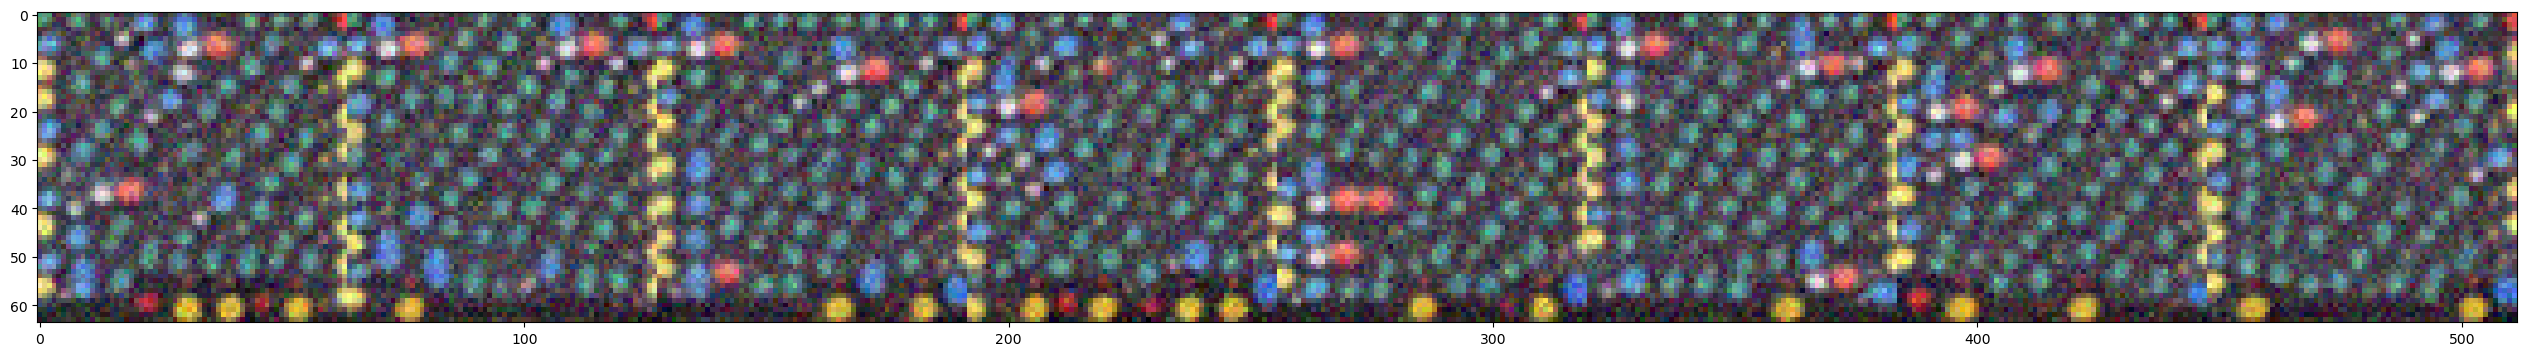

In [64]:
plot_images(samples)

In [21]:
c_noise = 3
channel_n = 90
perception_size = 360
hidden_size = 1024

ca_diff = CADiff(c_in=channel_n, c_noise=c_noise, hidden_size=hidden_size, 
                 perception_size=perception_size).to(device)

diffusion = Diffusion(c_in=channel_n, c_noise=c_noise, noise_steps=500)

train_diff = TrainDiff(ca_diff, diffusion, dataloader=dataset_dtd, c_in=channel_n,
                       c_noise=c_noise, run_name="tester")

losses = train_diff.train(epochs=1)            


06:00:28 - INFO: Starting epoch 0:
100%|████████████████████████████████████████████████████████████████████████████████████████| 125/125 [01:11<00:00,  1.74it/s, MSE=1.1]
06:01:39 - INFO: Sampling 8 new images...


Sampling 8 images


499it [01:12,  6.89it/s]


Saved array under losses/tester name to disk


In [18]:
loaders = torch.load('mnist_classed.pkl')
dataloader_0 = loaders[0] # MNIST for the 0 class

# subloader_mnist = get_dataloader()

c_noise = 1
channel_n = 90
perception_size = 360
hidden_size = 1024


ca_diff = CADiff(c_in=channel_n, c_noise=c_noise, hidden_size=hidden_size, 
                 perception_size=perception_size).to(device)

diffusion = Diffusion(c_in=channel_n, c_noise=c_noise, noise_steps=500)

ckpt = torch.load('./models/CADiff_big_polkadots/ckpt45.pt')
ca_diff.load_state_dict(ckpt)

# losses = load_np_array('CADiff_big_polkadots')
# plot_loss(losses)

train_diff = TrainDiff(ca_diff, diffusion, dataloader=dataloader_0, c_in=channel_n,
                       c_noise=c_noise, run_name="tester")

losses = train_diff.train(epochs=1)            


03:05:27 - INFO: Sampling 8 new images...


Sampling 8 images


9it [01:08,  7.58s/it]


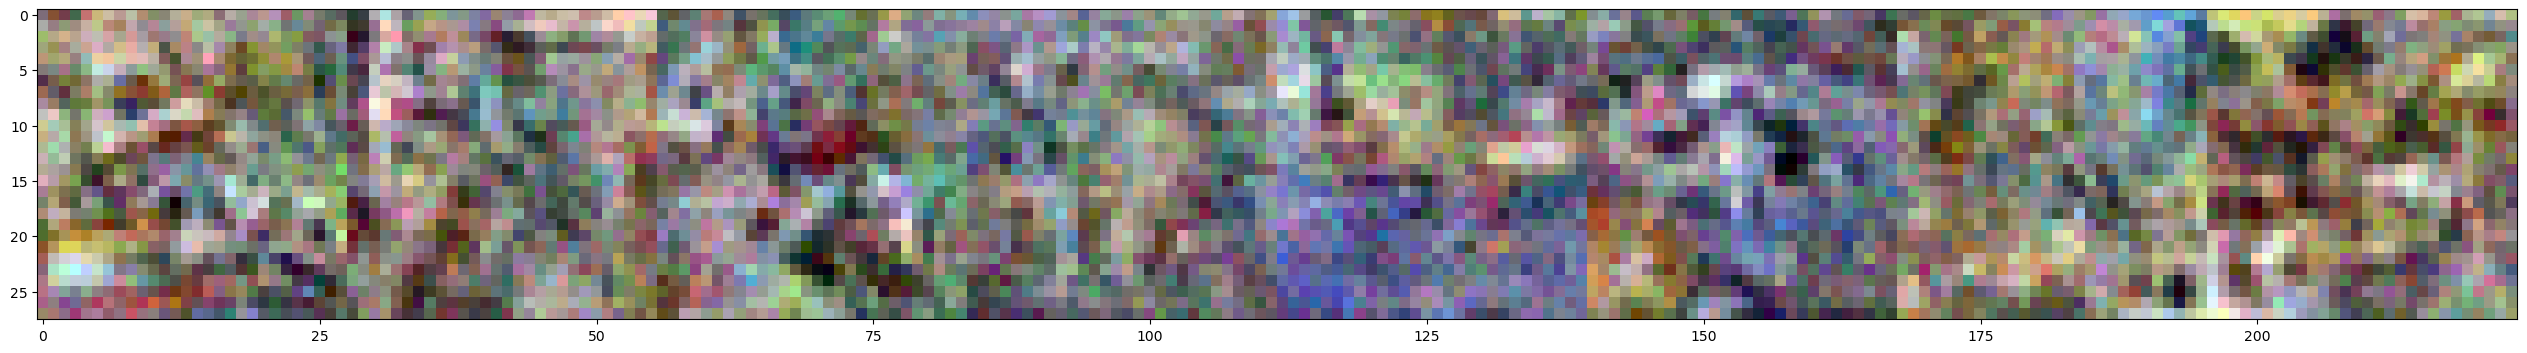

In [8]:
samples = diffusion.sample(ca_cifar, 8)
plot_images(samples)

04:18:33 - INFO: Sampling 8 new images...


Sampling 8 images


499it [01:47,  4.63it/s]


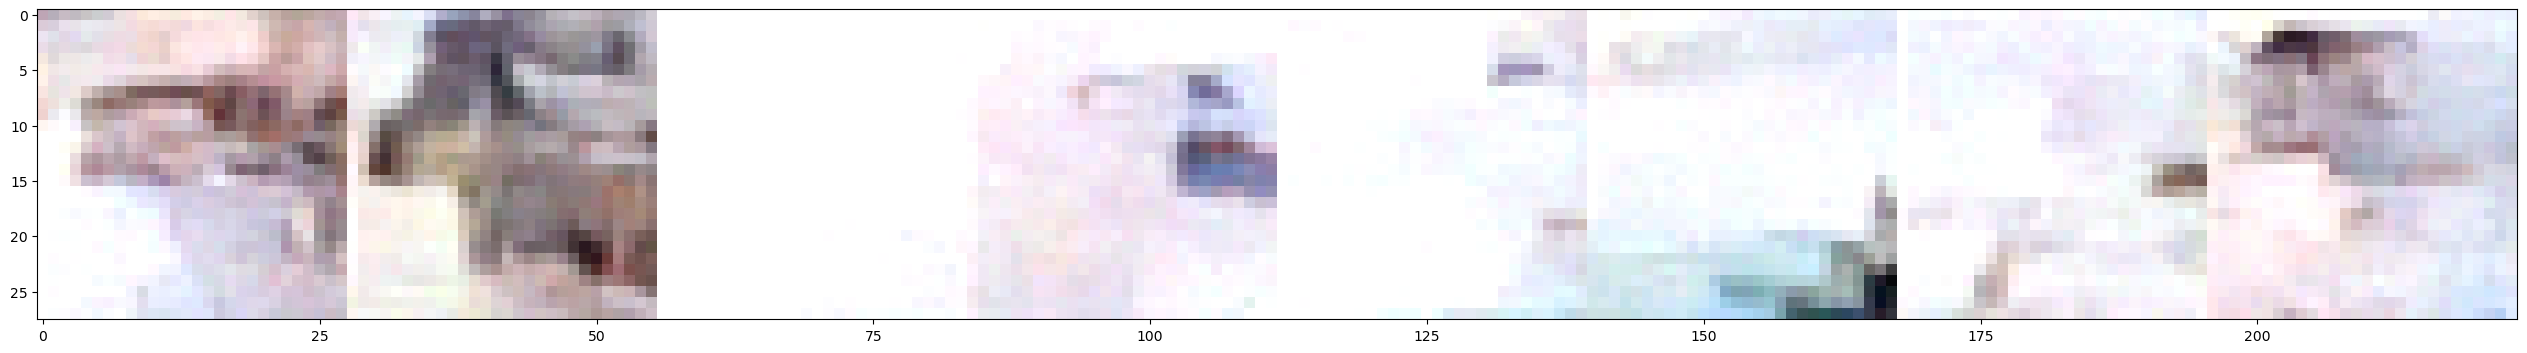

In [19]:
samples = diffusion.sample(ca_cifar, 8)
plot_images(samples)

In [ ]:
plot_images(example_data)
example_data.shape

In [16]:
c_noise = 1
channel_n = 90
perception_size = 360
hidden_size = 1024

ca_mnist = CADiff(c_in=channel_n, c_noise=c_noise, hidden_size=hidden_size, 
                 perception_size=perception_size).to(device)

ckpt = torch.load('./models/CADiff_massive_MNIST_all/ckpt435.pt')
ca_mnist.load_state_dict(ckpt)

losses_mnist = load_np_array('CADiff_massive_MNIST_all')
# plot_loss(losses_mnist)

diffusion = Diffusion(c_in=channel_n, c_noise=c_noise, noise_steps=500)

03:15:01 - INFO: Sampling 8 new images...


Sampling 8 images


499it [01:58,  4.22it/s]


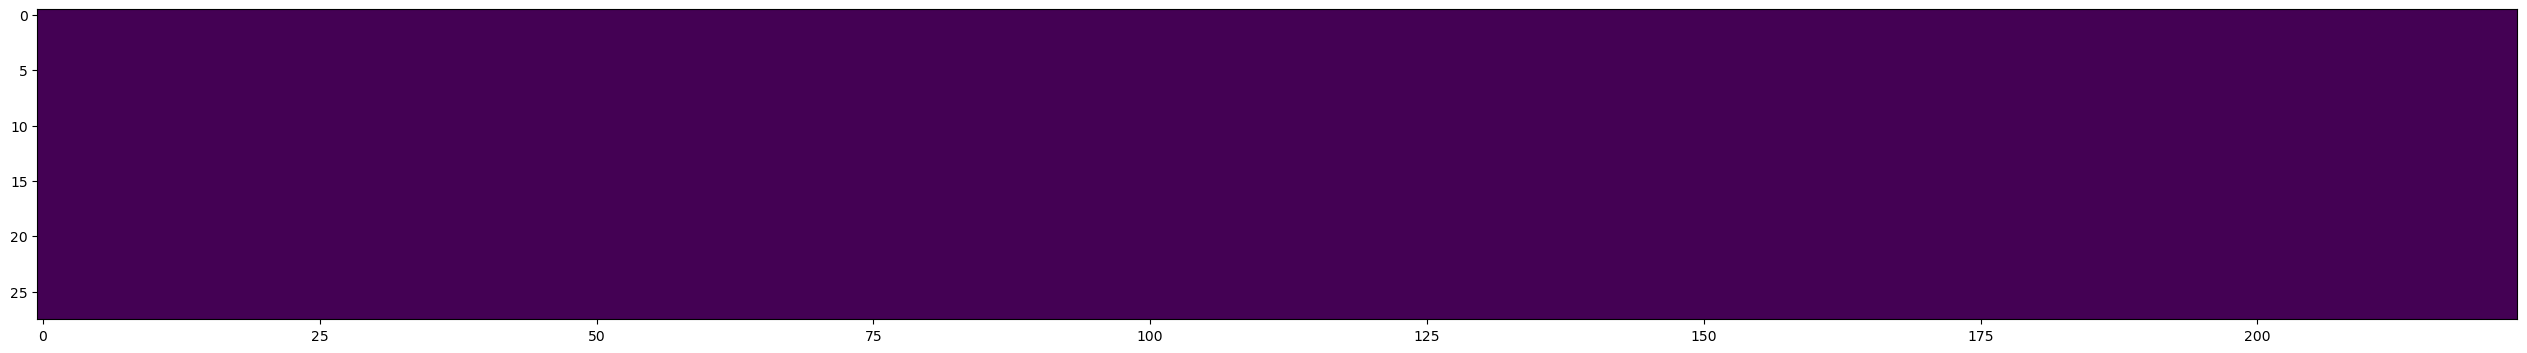

In [17]:
samples = diffusion.sample(ca_mnist, 8)
plot_images(samples)

In [68]:
for i, (images, _) in enumerate(dataloader_0):
    if i == len(dataloader_0) - 1:
        print(images.shape)

torch.Size([4, 1, 28, 28])


In [146]:
loaders = torch.load('mnist_classed.pkl')
dataloader_0 = loaders[0] # MNIST for the 0 class

# subloader_mnist = get_dataloader()

c_noise = 1
channel_n = 90
perception_size = 360
hidden_size = 1024


ca_diff = CADiff(c_in=channel_n, c_noise=c_noise, hidden_size=hidden_size, 
                 perception_size=perception_size).to(device)

diffusion = Diffusion(c_in=channel_n, c_noise=c_noise, noise_steps=500)

# ckpt = torch.load('./models/CADiff_big_polkadots/ckpt45.pt')
# ca_diff.load_state_dict(ckpt)

# losses = load_np_array('CADiff_big_polkadots')
# plot_loss(losses)

train_diff = TrainDiff(ca_diff, diffusion, dataloader=dataloader_0, c_in=channel_n,
                       c_noise=c_noise, run_name="tester")

losses = train_diff.train(epochs=1)            


06:29:45 - INFO: Starting epoch 0:
100%|███████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:29<00:00,  4.23it/s, MSE=2.25]
06:30:14 - INFO: Sampling 8 new images...
499it [01:00,  8.30it/s]

Saved array under losses/tester name to disk


05:38:46 - INFO: Sampling 8 new images...
499it [00:36, 13.55it/s]


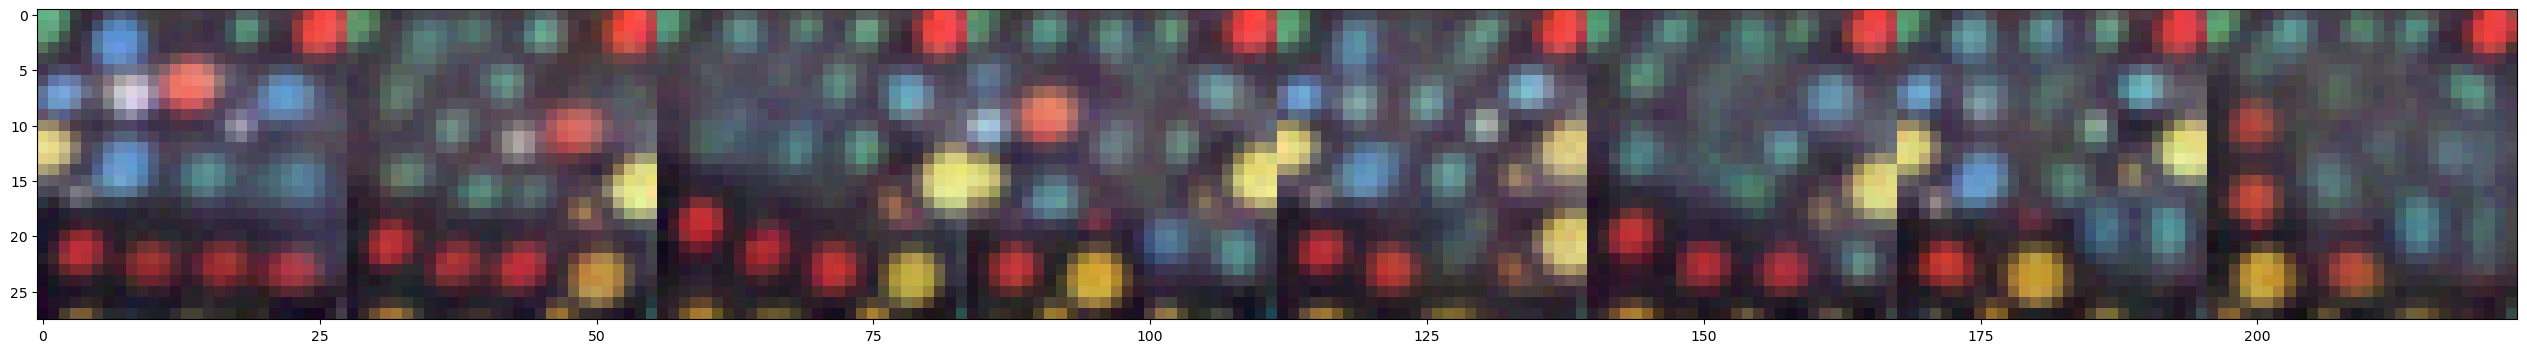

In [126]:
samples = diffusion.sample(ca_diff, 8)
plot_images(samples)

05:30:19 - INFO: Sampling 8 new images...
499it [00:41, 12.08it/s]


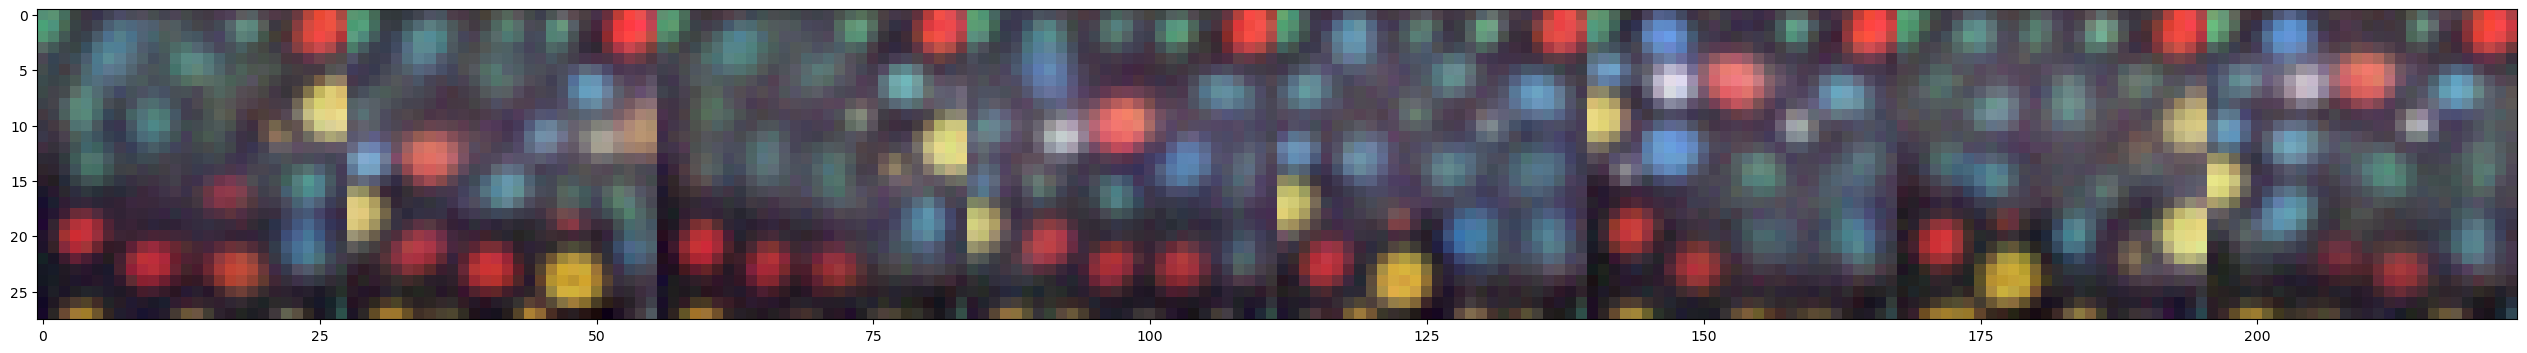

In [111]:
samples = diffusion.sample(ca_diff, 8)
plot_images(samples)

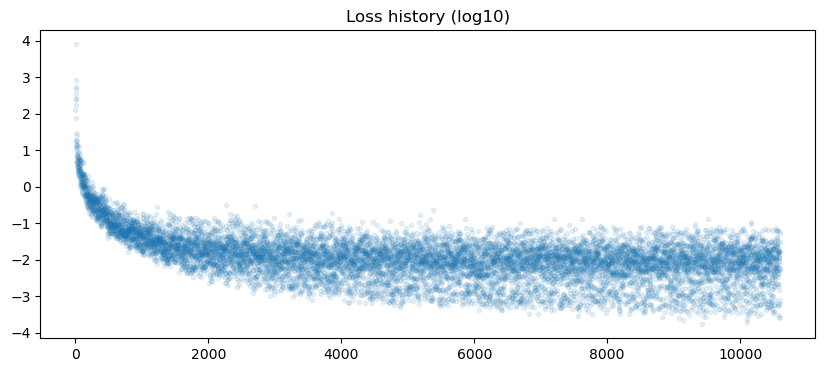

<All keys matched successfully>

In [141]:

c_noise = 1
ca_diff_mnist = CADiff(c_in=channel_n, c_noise=c_noise, hidden_size=hidden_size, 
                 perception_size=perception_size).to(device)

diffusion_mnist = Diffusion(c_in=channel_n, c_noise=c_noise, noise_steps=1000)

losses = load_np_array('CADiff_big1000_MNIST_all')
plot_loss(losses)

ckpt = torch.load('./models/CADiff_big1000_MNIST_all/ckpt105.pt')
ca_diff_mnist.load_state_dict(ckpt)

06:20:39 - INFO: Sampling 8 new images...
999it [01:19, 12.60it/s]


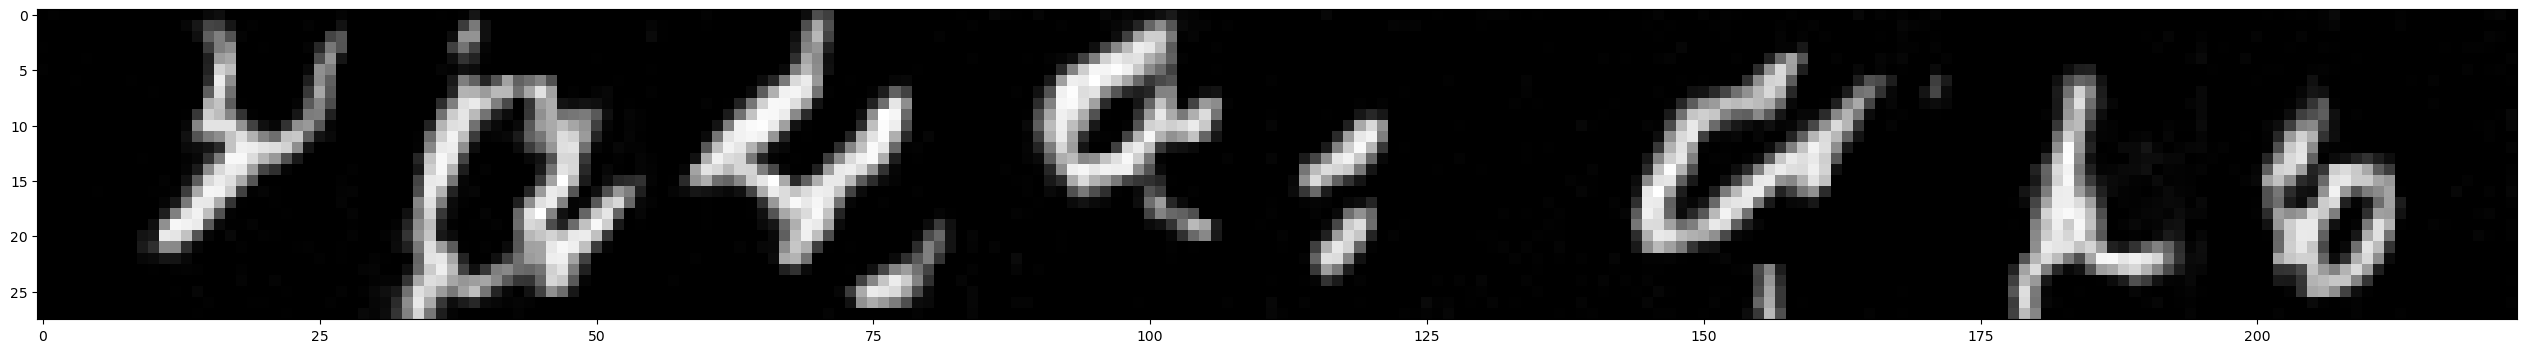

In [142]:
samples = diffusion_mnist.sample(ca_diff_mnist, 8)
plot_images(samples)

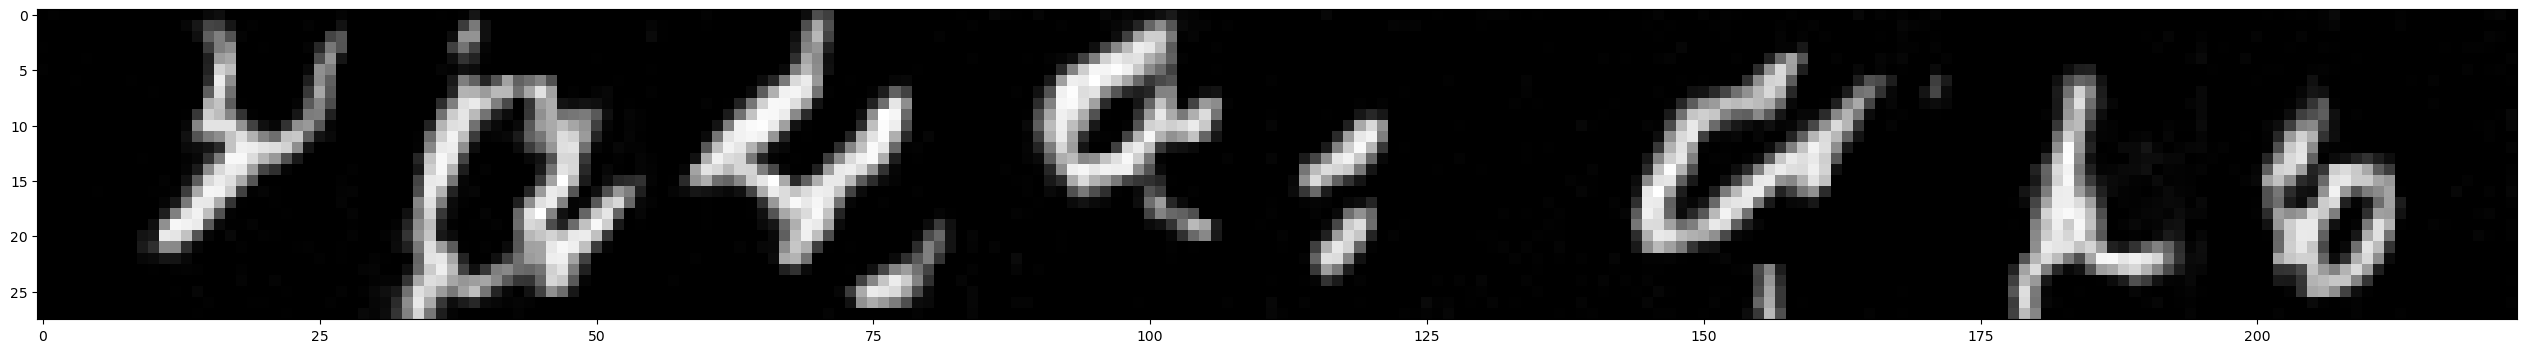

In [150]:
def plot_images(images):
    # Expect PyTorch shaping convention
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1)
    ], dim=-2).permute(1, 2, 0).cpu(), cmap='gray')
    plt.show()
plot_images(samples)

In [311]:
# Download classed MNIST

loaders = torch.load('mnist_classed.pkl')
dataloader_0 = loaders[0] # MNIST for the 0 class

In [371]:
idx, (data, _) = next(enumerate(dataloader_0))
data.shape

torch.Size([8, 1, 64, 64])

In [304]:
# CA Parameters

CHANNEL_N = 16
HIDDEN_SIZE = 128
PERCEPTION_SIZE = 48  # size of perception vector
BATCH_SIZE = 8
CELL_FIRE_RATE = 0.5
TARGET_PADDING = 16

In [387]:
K = 300 # enter your length here
dataset_mnist = torchvision.datasets.MNIST(root='datasets', train=False, download=False, transform=transforms)
subsample_train_indices = torch.randperm(len(dataset_mnist))[:K]
subloader_mnist = torch.utils.data.DataLoader(dataset_mnist, batch_size=BATCH_SIZE, 
                          sampler=torch.utils.data.SubsetRandomSampler(subsample_train_indices))

In [388]:
len(subloader_mnist)

38

In [148]:
%%time

# Original CA Model

# channel_n = 90
# perception_size = 360
# hidden_size = 1024

channel_n = 16
perception_size = 48
hidden_size = 128

nca_model = NCAModel(channel_n=channel_n, hidden_size=hidden_size, 
                     perception_size=perception_size).to(device)


nca_model.load_state_dict(torch.load("./models/NCA_mnist_full/ckpt.pt"))

CPU times: user 5.24 ms, sys: 3.96 ms, total: 9.2 ms
Wall time: 22.1 ms


<All keys matched successfully>

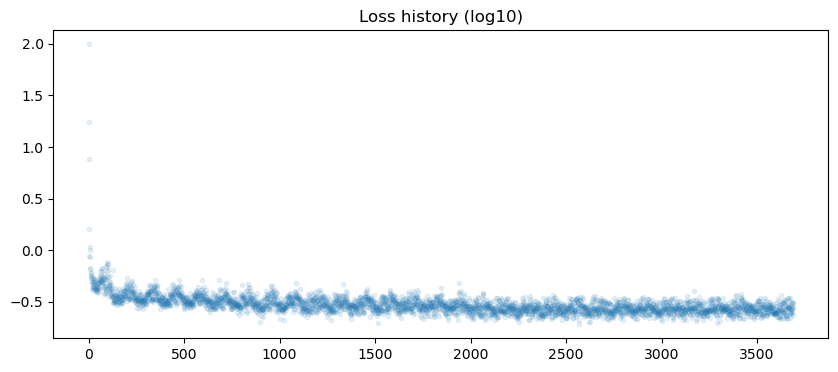

In [389]:
test_log = load_np_array("NCA_mnist_0")
plot_loss((test_log))

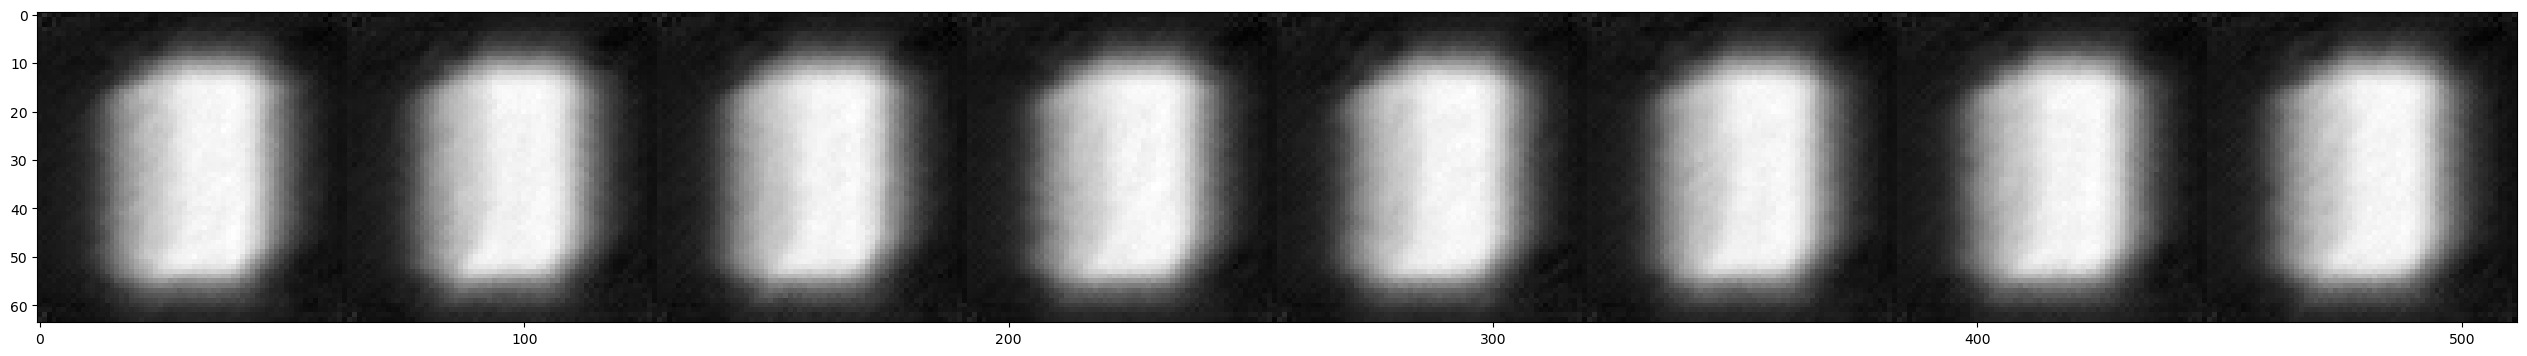

In [151]:


x0 = torch.randn((8, 16, 64, 64)).to(device)
x = x0
for _ in range(60):
    x, single_channel = nca_model(x)
plot_images(single_channel.detach())

In [338]:
sc = (sc.clamp(-1, 1) + 1) / 2
sc = (sc * 255).type(torch.uint8)

In [339]:
sc.dtype, sc.min(), sc.max()

(torch.uint8,
 tensor(0, device='cuda:2', dtype=torch.uint8),
 tensor(255, device='cuda:2', dtype=torch.uint8))

(array([3032., 2275., 3421., 4075., 4682., 4404., 3971., 2829., 1954.,
        2125.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

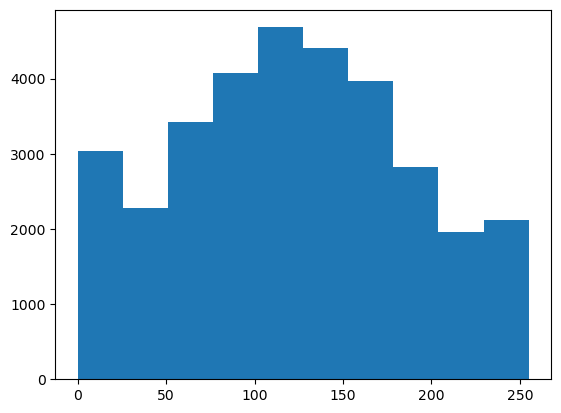

In [342]:
plt.hist(sc.detach().cpu().flatten())

05:45:29 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8]) tensor([33, 83, 27, 24, 69, 71, 56, 83], device='cuda:2')


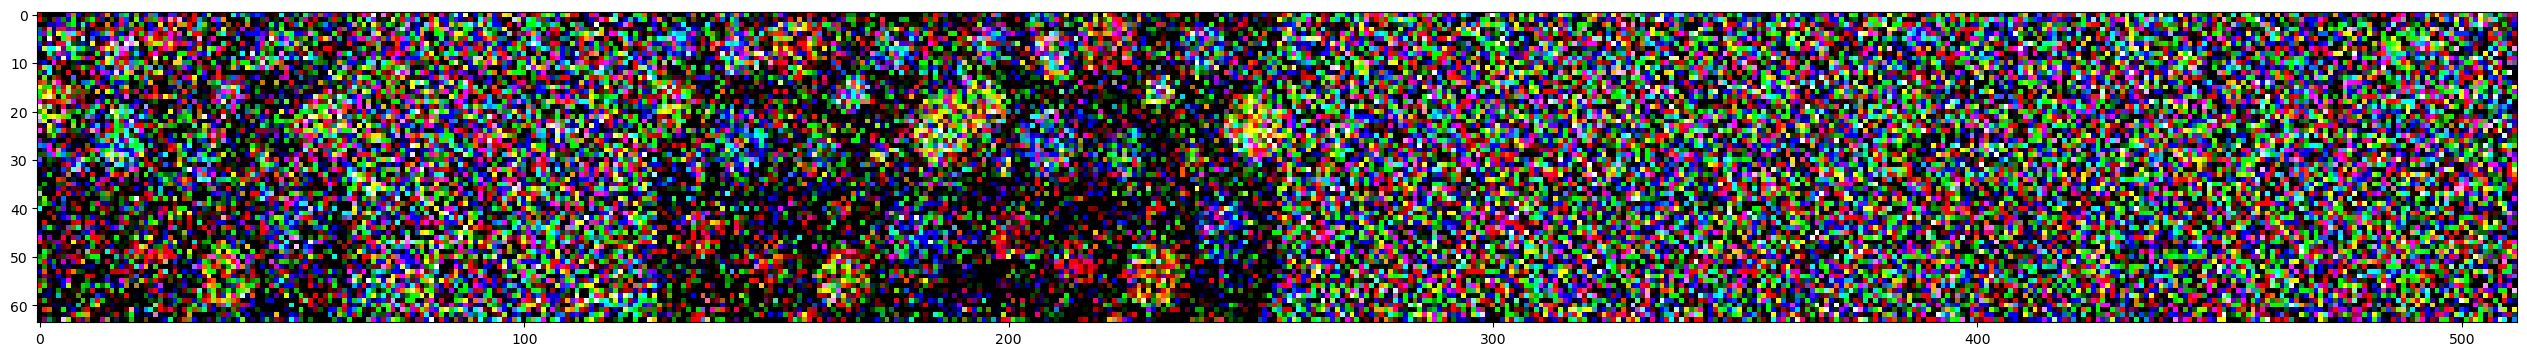

05:45:29 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


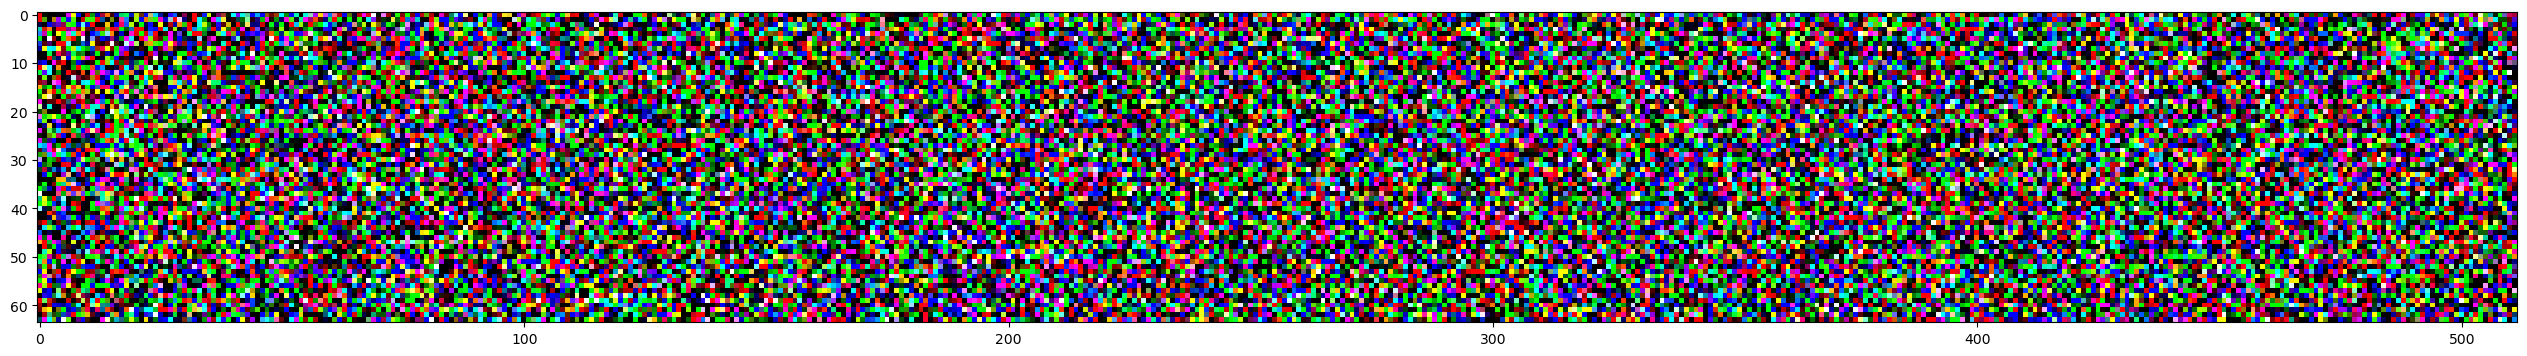

In [162]:
t = diffusion.sample_timesteps(image.shape[0]).to(device)
print(t.shape, t)

noised_image, noise = diffusion.noise_images(image, t)
plot_images(noised_image)
plot_images(noise)

In [189]:
print(noised_image.shape)

test = torch.repeat_interleave(noised_image, 4, dim=1)
tiled = torch.tile(noised_image, (1, 4, 1, 1))
print(test.shape)
print(test[:, 3:6, ...].shape)
print()
print(tiled.shape)
print(tiled[:, 3:6, ...].shape)

torch.Size([8, 3, 64, 64])
torch.Size([8, 12, 64, 64])
torch.Size([8, 3, 64, 64])

torch.Size([8, 12, 64, 64])
torch.Size([8, 3, 64, 64])


05:50:50 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


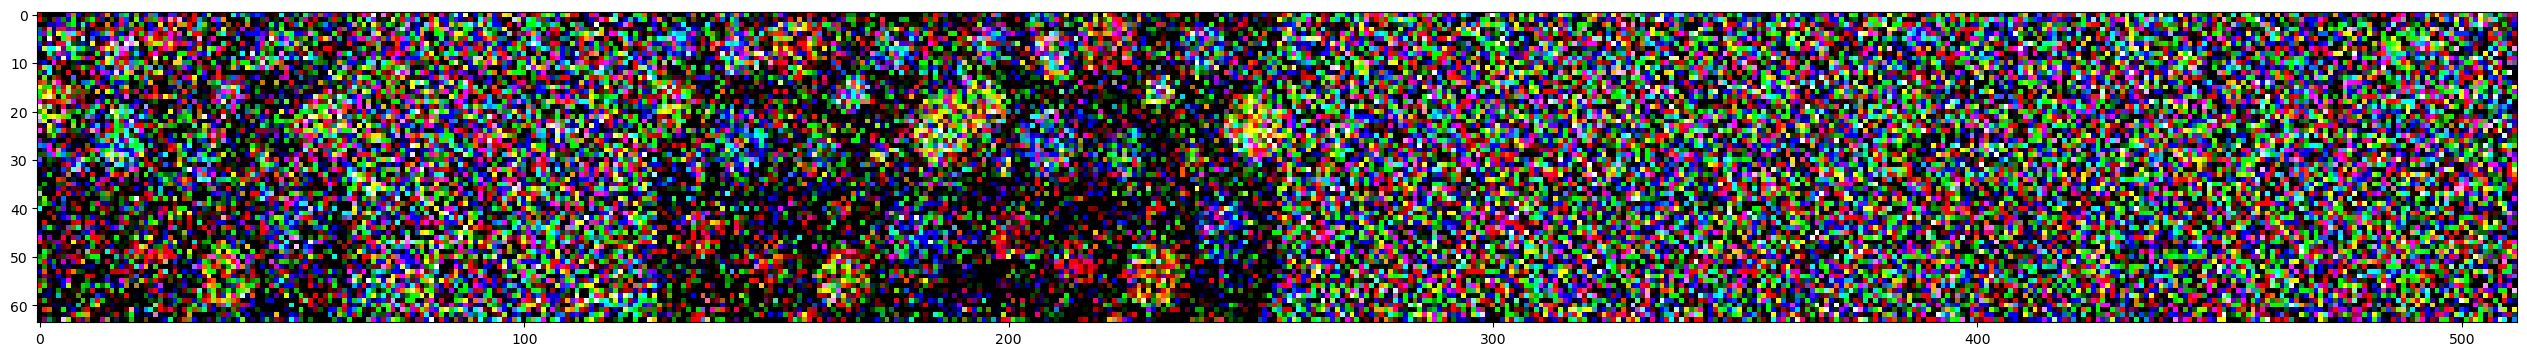

True

In [182]:
plot_images(tiled[:, 3:6, ...])
torch.allclose(tiled[:, 3:6, ...], noised_image)

In [298]:
# Custom helpers package
from noised_rgb import CANet, DiffusionCA, Train

# Reload
importlib.reload(sys.modules['noised_rgb'])
from noised_rgb import CANet, DiffusionCA, Train

Finished imports from file
device is cuda:2


In [299]:
%%time

c_noise = 3
c_in = 90
p_size = 360
h_size = 1024

# c_noise = 3
# c_in = 3
# p_size = 15 
# h_size = 128
device = 2
ca = CANet(c_in=c_in, c_noise=c_noise, perception_size=p_size, hidden_size=h_size).to(device)
diffusion = DiffusionCA(c_in=c_in, c_noise=c_noise, noise_steps=1000)

# ckpt = torch.load("./models/polkadots_large/ckpt.pt")
# ca.load_state_dict(ckpt)

train = Train(ca, diffusion, emoji_dataloader, run_name="test_run", c_noise=c_noise)
train.train(epochs=1)

10:15:18 - INFO: Starting epoch 0:
  0%|                                                                                                           | 0/200 [00:00<?, ?it/s]


TypeError: expected Tensor as element 1 in argument 0, but got NoneType

In [292]:
tester = torch.randn(8, 10, 20, 20)
new1 = torch.randn(8, 3, 20, 20)

tester[:, :3, :, :] = new1
tester.shape

torch.Size([8, 10, 20, 20])

In [290]:
tester2 = tester[:, 3:, :, :]
print(tester2.shape)

tester3 = torch.cat((new1, tester2), dim=1)
print(tester3.shape)

torch.Size([8, 7, 20, 20])
torch.Size([8, 10, 20, 20])


In [291]:
torch.allclose(tester, tester3)

True

07:35:27 - INFO: Sampling 8 new images...
999it [00:13, 74.04it/s] 


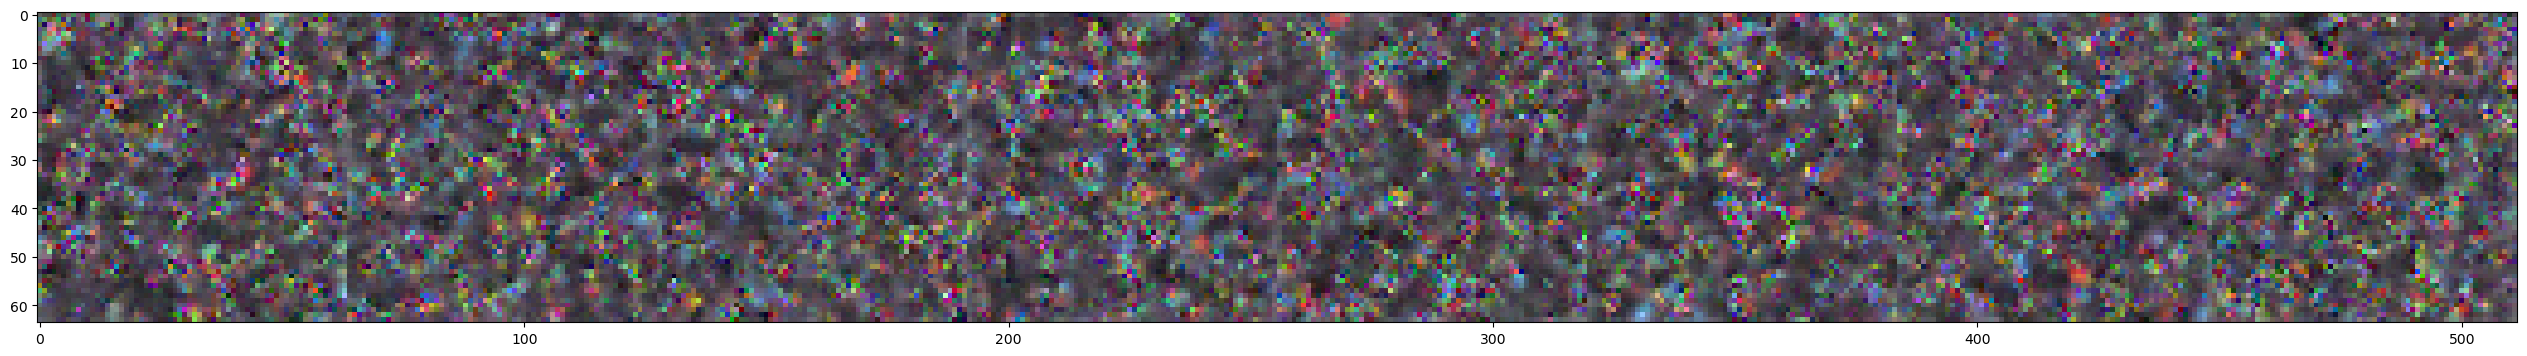

In [276]:
samples = diffusion.sample(ca, 8)
plot_images(samples)

(array([47291.,  1746.,  2881.,  3282.,  3300.,  2678.,  1841.,   981.,
          604., 33700.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

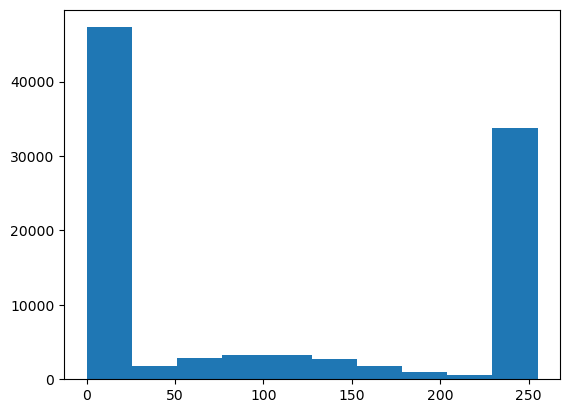

In [277]:
plt.hist(sampled_images.cpu().flatten())

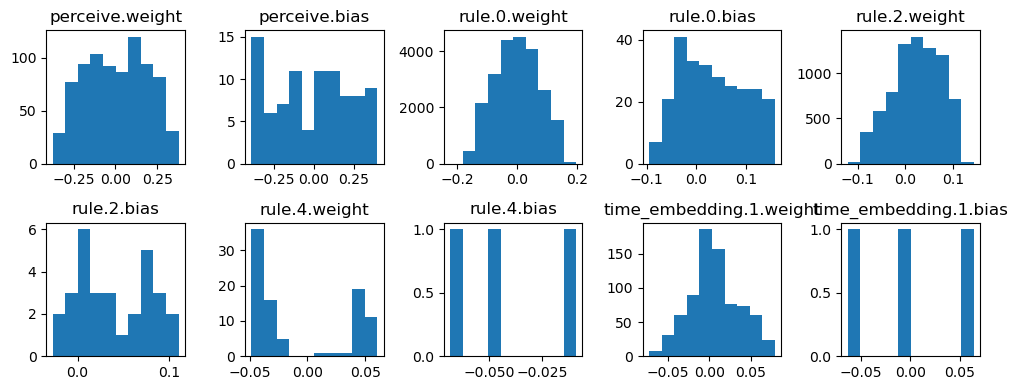

In [230]:
def plot_weights(model):
    # Assumes 10 total things to plot
    
    fig, ax2d = plt.subplots(2, 5, squeeze=False, figsize=(10, 4))
    axli = ax2d.flatten()

    for i, (name, p) in enumerate(model.named_parameters()):
        # print(name)
        # print(torch.allclose(p, torch.zeros_like(p), 2))
        axli[i].hist(p.detach().cpu().flatten())
        axli[i].set_title(name)

    fig.tight_layout()
    fig.show()
 
plot_weights(ca)

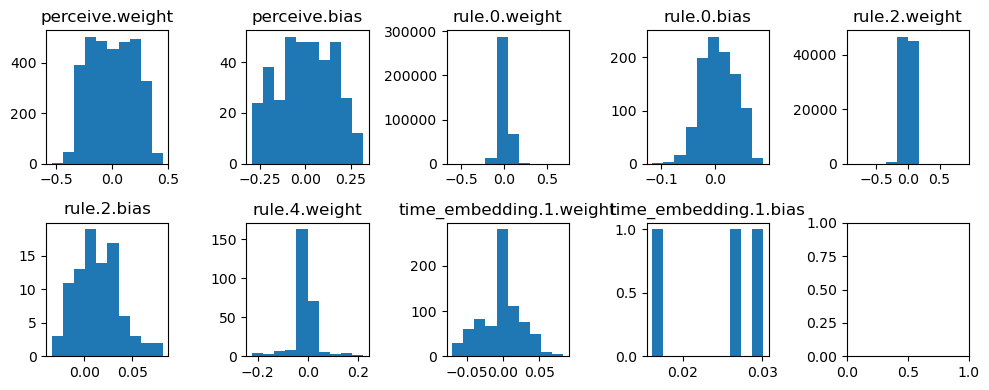

In [ ]:
plot_weights(ca)

In [198]:
sampled_images.min(), sampled_images.max()

(tensor(0, device='cuda:2', dtype=torch.uint8),
 tensor(0, device='cuda:2', dtype=torch.uint8))

In [295]:
# Reload
importlib.reload(sys.modules['unet'])
from unet import UNet, DiffusionUNet, TrainUNet

device is cuda:2


In [135]:
%%time

unet = UNet(device=device).to(device)
diffusion_unet = DiffusionUNet(device=device)

train_unet = TrainUNet(unet, diffusion_unet, emoji_dataloader, "unet_polkadots")
train_unet.train(epochs=1)

05:19:37 - INFO: Starting epoch 0:
100%|█████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:45<00:00,  4.38it/s, MSE=0.0813]
05:20:23 - INFO: Sampling 8 new images....
999it [01:04, 15.40it/s]


CPU times: user 1min 37s, sys: 7.61 s, total: 1min 45s
Wall time: 1min 53s


05:22:29 - INFO: Sampling 8 new images....
999it [01:04, 15.47it/s]


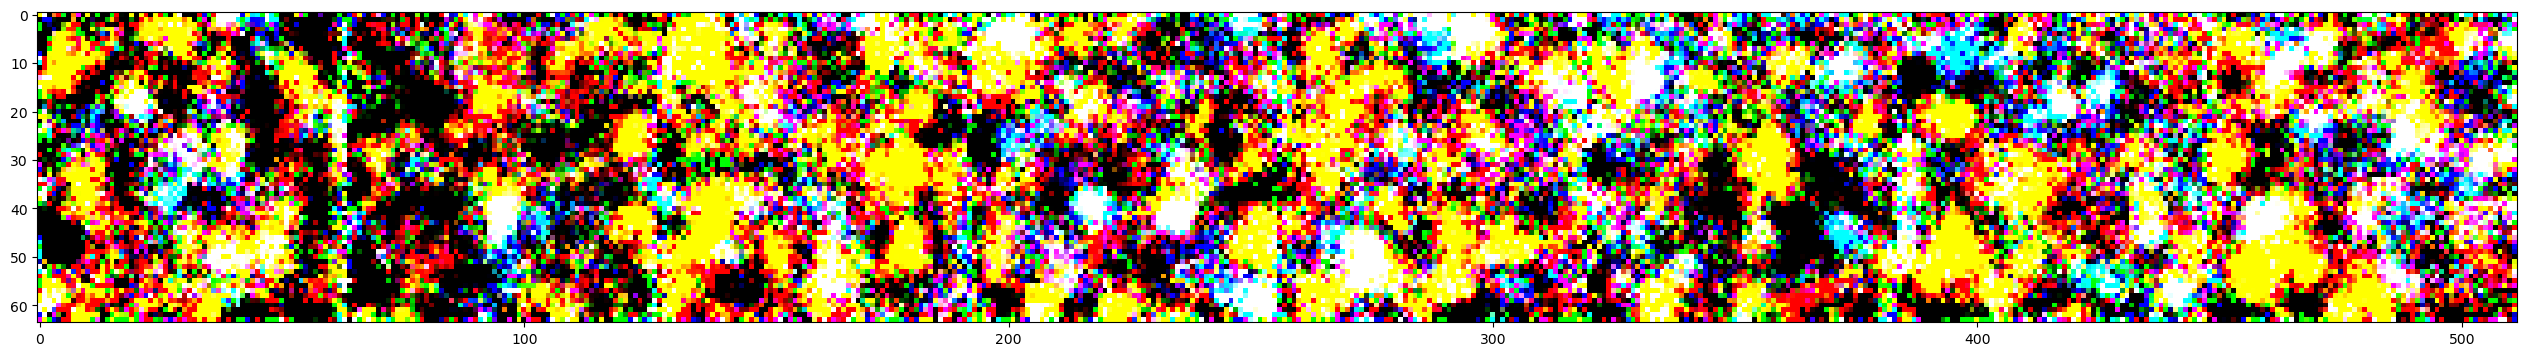

CPU times: user 1min 6s, sys: 554 ms, total: 1min 7s
Wall time: 1min 4s


In [136]:
%%time
unet_samples = diffusion_unet.sample(unet, 8)
plot_images(unet_samples)

torch.uint8 tensor(0, device='cuda:2', dtype=torch.uint8) tensor(255, device='cuda:2', dtype=torch.uint8)


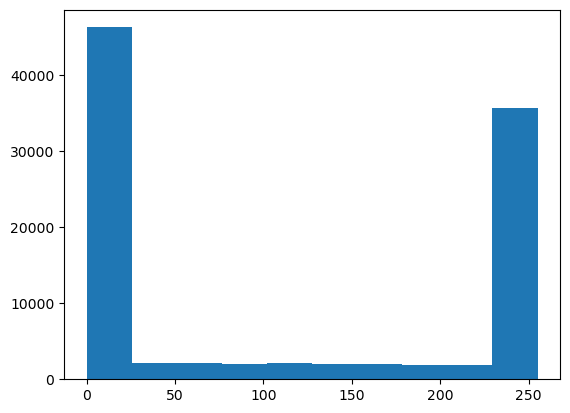

In [137]:
plt.hist(unet_samples.cpu().flatten())
print(unet_samples.dtype, unet_samples.min(), unet_samples.max())